In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.interpolate as it
import scipy.integrate as integ
import scipy.special as spec
import scipy.optimize as opt

In [2]:
pk_noint_dat=np.loadtxt('../gadget_noint_pk_cb.dat')
pk_variant_dat=np.loadtxt('../gadget_noint_variant_pk_cb.dat')

In [4]:
dat_noint_gpc = np.loadtxt('Noint-Gpc/fof_z=0.0.dat')
dat_variant_gpc = np.loadtxt('Noint-variant-Gpc/fof_z=0.0.dat')

In [5]:
noint_dndm_gpc = dat_noint_gpc[:,1]
noint_ms_gpc = dat_noint_gpc[:,3]

variant_dndm_gpc = dat_variant_gpc[:,1]
variant_ms_gpc = dat_variant_gpc[:,3]

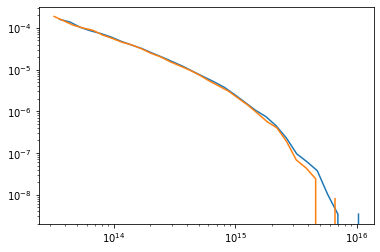

In [6]:
plt.loglog(noint_ms_gpc,noint_dndm_gpc)
plt.loglog(variant_ms_gpc,variant_dndm_gpc)

In [11]:
Omega_m = 0.31

Omega_m_variant = 0.29

h_noint = 0.678

h_variant = 0.7

def rho_crit(h):
    return 2.7754e11 * h**2 # Msun/Mpc^3
#rho_crit = 2.7754e20 * h**2 # Msun/Gpc^3

def rho_bar(Omega,rho_c):
    return Omega*rho_c

def Wfunc(x):
    return (3/x**3) * (np.sin(x) - x*np.cos(x))

def R_of_m(m,rhobar):
    return (3*m / (4*np.pi*rhobar) )**(1/3)



def sigma_lin_trapz(m, powerspecfile,h,rhobar):
    if type(m) == np.ndarray:
        results = np.zeros(m.size)
        for i in range(results.size):
            #result, error = integ.quad(lambda k: k**2 * powerspec(k) * (Wfunc(k*R_of_m(m[i])))**2 /2/np.pi**2, 0, np.inf,limit=200)
            k=powerspecfile[:,0]
            pk = powerspecfile[:,1]
            result = np.trapz(k**2 * pk * (Wfunc(k*h*R_of_m(m[i],rhobar)))**2 /2/np.pi**2 ,k)
            results[i]=result
            #if error/result > precision:
            #    print('Large error='+str(error)+' for sigma='+str(result)+ ' for m=' +str(m[i]))
        return results
    else: 
        #result, error = integ.quad(lambda k: k**2 * powerspec(k) * (Wfunc(k*R_of_m(m)))**2 /2/np.pi**2, 0, np.inf,limit=200)
        #print(result)
        #print(error)
        k=powerspecfile[:,0]
        pk = powerspecfile[:,1]
        result = np.trapz(k**2 * pk * (Wfunc(k*h*R_of_m(m[i],rhobar)))**2 /2/np.pi**2 ,k)
        return result
    
def A_st(p,q):
    return 2**(p+0.5) * q**0.5 / (2**p * np.pi**0.5 + spec.gamma(0.5-p))

def fnu_st_func(nu, p, q):
    return A_st(p,q) * (1 + (q*nu**2)**(-p)) * np.exp(-q*nu**2 /2)

def modified_ST(halomasses, pk, Omega=Omega_m,h=h_noint, p= 0.3, q= 0.707, delta= 1.686):
    rho_c = rho_crit(h)
    rhobar = rho_bar(Omega,rho_c)
    sigmasq =sigma_lin_trapz(halomasses, pk,h, rhobar)
    nus = delta/np.sqrt(sigmasq)
    fnu = fnu_st_func(nus,p,q)

    M_of_nu = it.InterpolatedUnivariateSpline(nus,halomasses)
    dMdnu = M_of_nu.derivative()

    F_of_m = fnu * rhobar /halomasses / dMdnu(nus)

    dndlogm = F_of_m*halomasses
    
    return dndlogm


In [14]:
halomasses = np.logspace(13,16.1)

In [15]:
hmf_noint = modified_ST(halomasses,pk_noint_dat)

hmf_variant = modified_ST(halomasses,pk_variant_dat,Omega=Omega_m_variant,h=h_variant)

In [22]:
plt.figure(figsize=(16,10))
plt.loglog(noint_ms_gpc,noint_dndm_gpc,'r')
plt.loglog(variant_ms_gpc,variant_dndm_gpc,'b')

plt.loglog(halomasses,hmf_noint,'r--')
plt.loglog(halomasses,hmf_variant,'b--')

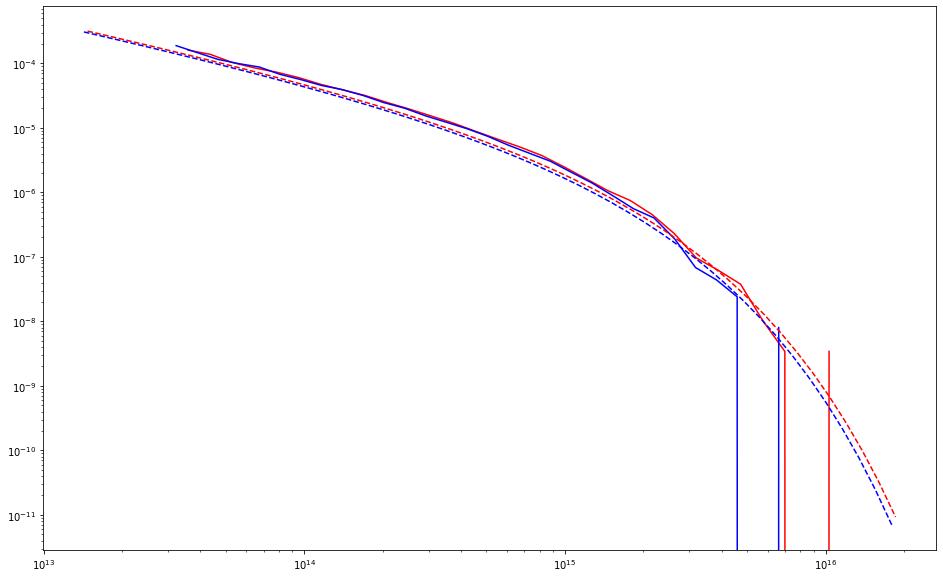

In [20]:
plt.figure(figsize=(16,10))
plt.loglog(noint_ms_gpc,noint_dndm_gpc,'r')
plt.loglog(variant_ms_gpc,variant_dndm_gpc,'b')

plt.loglog(halomasses/h_noint,hmf_noint/h_noint,'r--')
plt.loglog(halomasses/h_variant,hmf_variant/h_variant,'b--')